In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Font which got unicode math stuff.
import matplotlib as mpl
mpl.rcParams['font.family'] = 'DejaVu Sans'

# Much more readable plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Make NaNs black in my fav. colormaps:
mpl.cm.Spectral.set_bad(color=(0,0,0), alpha=1)
mpl.cm.Spectral_r.set_bad(color=(0,0,0), alpha=1)

# Much better than plt.subplots()
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
import numpy as np

# New-style RNGs, also 3x faster for .choice(HUGE,small,replace=False)
from numpy.random import default_rng
rg = default_rng(12345)

In [3]:
!head -n 2 pub_matches_7.22-2019-09-28.csv

Manually loading the data is faster than using `np.genfromtxt` and allows us to "splat" the teams into multiple columns, dramatically reducing memory (as opposed to an array of objects, that being sets).
The only caveat is that we need to know the number of rows upfront.

In [4]:
N = 13025004
Ntrain = 10000000
pub = np.empty((N, 5+5+1), dtype=np.uint8)
blacklist = set()

In [5]:
with open('pub_matches_7.22-2019-09-28.csv', 'r') as f:
    header = f.readline()
    for i, line in enumerate(f):
        fields = line.strip().split(',')
        try:
            pub[i,:5] = [int(f) for f in fields[0].split(':')]
            pub[i,5:10] = [int(f) for f in fields[1].split(':')]
            pub[i,10] = fields[4] == 'False'  # Winner: 0 = radiant, 1 = dire
        except ValueError:
            pub[i] = 0
            blacklist.add(i)
            print("Skipping entry {} (match ID {})".format(i, fields[2]))

blacklist = np.array(list(sorted(blacklist)))

Skipping entry 184311 (match ID 5040684902)
Skipping entry 344339 (match ID 5037255315)
Skipping entry 500443 (match ID 5030583812)
Skipping entry 777627 (match ID 5026117208)
Skipping entry 1406124 (match ID 5015904011)
Skipping entry 1910780 (match ID 5007641015)
Skipping entry 2420430 (match ID 4998907007)
Skipping entry 3239937 (match ID 4984790700)
Skipping entry 5802607 (match ID 4938618606)
Skipping entry 5912010 (match ID 4936272403)
Skipping entry 6127973 (match ID 4931792813)
Skipping entry 7114441 (match ID 4912127007)
Skipping entry 8525726 (match ID 4885268414)
Skipping entry 8759550 (match ID 4880641719)
Skipping entry 9549778 (match ID 4864344905)
Skipping entry 11263387 (match ID 4826389600)
Skipping entry 11725351 (match ID 4814899504)
Skipping entry 12855562 (match ID 4786383117)
Skipping entry 12995337 (match ID 4782932205)
Skipping entry 12997710 (match ID 4782866703)
Skipping entry 12998572 (match ID 4782840609)


In [6]:
import json

In [7]:
with open('dotaconstants/build/heroes.json', 'r') as f:
    heros = json.load(f)

In [8]:
heros[str(129)]

{'id': 129,
 'name': 'npc_dota_hero_mars',
 'localized_name': 'Mars',
 'primary_attr': 'str',
 'attack_type': 'Melee',
 'roles': ['Carry', 'Initiator', 'Disabler', 'Durable'],
 'img': '/apps/dota2/images/heroes/mars_full.png?',
 'icon': '/apps/dota2/images/heroes/mars_icon.png',
 'base_health': 200,
 'base_health_regen': None,
 'base_mana': 75,
 'base_mana_regen': 0,
 'base_armor': -1,
 'base_mr': 25,
 'base_attack_min': 31,
 'base_attack_max': 39,
 'base_str': 23,
 'base_agi': 20,
 'base_int': 17,
 'str_gain': 3.2,
 'agi_gain': 1.9,
 'int_gain': 1.4,
 'attack_range': 250,
 'projectile_speed': 900,
 'attack_rate': 1.8,
 'move_speed': 310,
 'turn_rate': 0.8,
 'cm_enabled': True,
 'legs': 2}

In [9]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [10]:
import tensorflow as tf

In [11]:
class Embedding(tf.Module):
    def __init__(self, embdim, vocab=130, name=None):
        super(Embedding, self).__init__(name=name)
        self.w = tf.Variable(tf.random.normal([vocab, embdim]), name='emb')

    def __call__(self, ids):
        return tf.nn.embedding_lookup(self.w, ids)

In [12]:
def get_batch(bs=32, train=True):
    if train:
        indices = rg.choice(Ntrain, bs, replace=False)
    else:
        indices = Ntrain + rg.choice(N - Ntrain, bs, replace=False)

    # If we got something blacklisted, retry.
    if np.any(np.isin(indices, blacklist, assume_unique=True)):
        return get_batch(bs, train)

    rows = pub[indices]
    return tf.convert_to_tensor(rows[:,:-1].reshape(-1, 2, 5)), tf.convert_to_tensor(rows[:,-1])

In [340]:
%%timeit
get_batch()

94.1 µs ± 1.14 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [329]:
%load_ext line_profiler

In [343]:
%lprun -f get_batch get_batch()

In [13]:
def iter_test(bs=32):
    for i in range(Ntrain, N, bs):
        # Let's ignore about the 6 blacklisted cases.
        rows = pub[i:i+bs]
        embs = tf.convert_to_tensor(rows[:,:-1].reshape(-1, 2, 5))
        label = tf.convert_to_tensor(rows[:,-1])
        yield embs, label

# Model A: Linear Dot

In this model, we learn an embedding for each hero, a team's embeddings are simply averaged (so there is no interaction), and then each team's embeddings are dot-producted into a radiant/dire prediction.

This means that we essentially learn completely independent hero vectors, which do not influence eachother, and should pretty much correspond to a hero's Elo score if the vector was one-dimensional, but since it's higher-dimensional, corresponds to a cycle-safe Elo score.

In [366]:
emb_a = Embedding(16)
emb_a_orig = np.array(emb_a.w.numpy())

opt_a = tf.optimizers.Adam()
losses_a = []

In [367]:
embs, opt, losses = emb_a, opt_a, losses_a

for i in range(50000):
    if i % 1000 == 0:
        print('\r{}'.format(i), end='', flush=True)
    Xb, yb = get_batch()  # B25, B
    with tf.GradientTape() as tape:
        Eb = embs(tf.cast(Xb, tf.int32))  # B25E
        team_embs = tf.reduce_mean(Eb, axis=2)  # B2E
        logits = tf.einsum('ij,ij->i', team_embs[:,0,:], team_embs[:,1,:])  # Batched dot.
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=logits, labels=tf.cast(yb, tf.float32)))

    losses.append(loss.numpy())
    grads = tape.gradient(loss, emb_a.trainable_variables)
    opt.apply_gradients(zip(grads, emb_a.trainable_variables))

49000

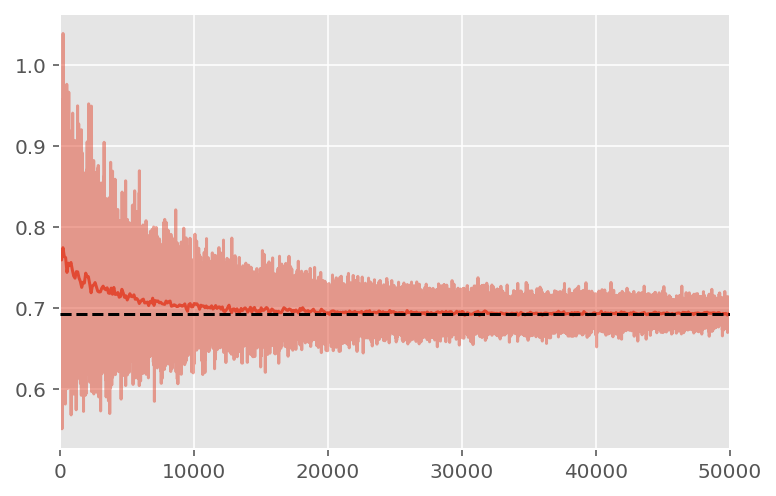

In [379]:
l, = plt.plot(np.arange(0, len(losses), 100), np.reshape(losses, (-1, 100)).mean(axis=-1))
plt.plot(losses, c=l.get_color(), alpha=0.5)
plt.xlim(0, len(losses))
plt.hlines(-np.log(0.5), *plt.xlim(), ls='--', zorder=5);

In [369]:
accs = []
for Xb, yb in iter_test(bs=1024):
    Eb = embs(tf.cast(Xb, tf.int32))  # B25E
    team_embs = tf.reduce_mean(Eb, axis=2)  # B2E
    logits = tf.einsum('ij,ij->i', team_embs[:,0,:], team_embs[:,1,:])  # Batched dot.
    acc = tf.reduce_mean(tf.cast(tf.cast(logits > 0, tf.uint8) == yb, tf.float32))
    accs.append(acc)
np.mean(accs)

0.509532

# Model B: mElo$_{2k}$

Should be very similar to the above, except the prediction is done using the formula from the paper, computing the probability of team $i$ beating team $j$:

$$
p_{ij} = \sigma(r_i - r_j + \mathbf{c}_i^T \cdot \Omega_{2k \times 2k} \cdot \mathbf{c}_j), 
~~~~ \text{where} ~~~~ \Omega_{2k \times 2k} = \sum_{i=1}^{k} \left(\mathbf{e}_{2i-1} \mathbf{e}_{2i}^T - \mathbf{e}_{2i} \mathbf{e}_{2i-1}^T\right)
$$

where vectors are column vectors. So, for $k=1$, this boils down to:

$$
\Omega_{2k \times 2k} = \begin{pmatrix}0 & 1\\-1 & 0\end{pmatrix}
~~~~ \Longrightarrow ~~~~
p_{ij}
= \sigma\left(r_i - r_j + \begin{pmatrix}-c_i^2 & c_i^1\end{pmatrix} \cdot \begin{pmatrix}c_j^1\\c_j^2\end{pmatrix}\right)
= \sigma\left(r_i - r_j + c_i^1 c_j^2 - c_i^2 c_j^1\right)
$$

In [414]:
emb_b = Embedding(3)
emb_b_orig = np.array(emb_b.w.numpy())

opt_b = tf.optimizers.Adam()
#opt_b = tf.optimizers.SGD(learning_rate=0.1)
losses_b = []

In [415]:
embs, opt, losses = emb_b, opt_b, losses_b

for i in range(5*1000*1000):
    if i % 1000 == 0:
        print('\r{}'.format(i), end='', flush=True)
    #print('\rBatch...', end='', flush=True)
    Xb, yb = get_batch()  # B25, B
    #print('\rfprop...', end='', flush=True)
    with tf.GradientTape() as tape:
        Eb = embs(tf.cast(Xb, tf.int32))  # B25E
        team_embs = tf.reduce_mean(Eb, axis=2)  # B2E

        # De-construct into r and c from the formula:
        # Select i == dire, j == radiant, because label 0 == radiant win, 1 == dire win
        ri, rj = team_embs[:,1,0], team_embs[:,0,0]
        ci1, cj1 = team_embs[:,1,1], team_embs[:,0,1]
        ci2, cj2 = team_embs[:,1,2], team_embs[:,0,2]
        logits = ri - rj + ci1*cj2 - ci2*cj1

        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=logits, labels=tf.cast(yb, tf.float32)))

    losses.append(loss.numpy())
    #print('\rbprop...', end='', flush=True)
    grads = tape.gradient(loss, embs.trainable_variables)
    opt.apply_gradients(zip(grads, embs.trainable_variables))

4999000

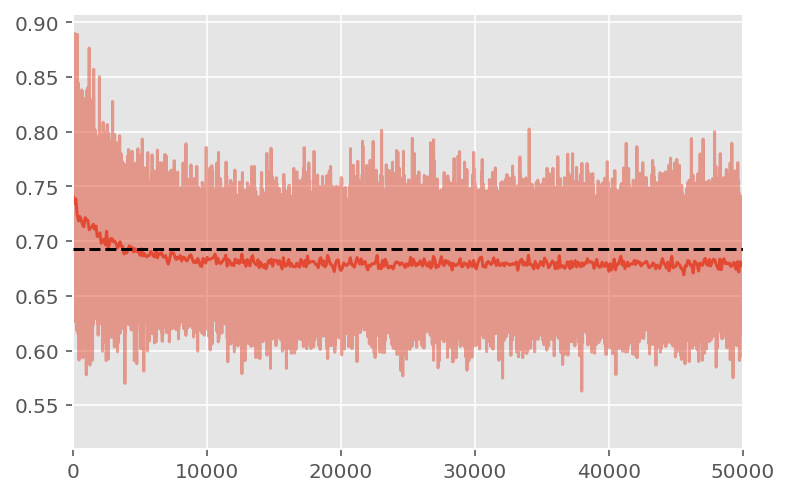

In [417]:
l, = plt.plot(np.arange(0, len(losses_b), 100), np.reshape(losses_b, (-1, 100)).mean(axis=-1))
plt.plot(losses_b, c=l.get_color(), alpha=0.5)
#plt.xlim(0, len(losses_b))
plt.xlim(0, 50000)
plt.hlines(-np.log(0.5), *plt.xlim(), ls='--', zorder=5);

In [418]:
accs = []
for i, (Xb, yb) in enumerate(iter_test(bs=1024)):
    Eb = embs(tf.cast(Xb, tf.int32))  # B25E
    team_embs = tf.reduce_mean(Eb, axis=2)  # B2E

    ri, rj = team_embs[:,1,0], team_embs[:,0,0]
    ci1, cj1 = team_embs[:,1,1], team_embs[:,0,1]
    ci2, cj2 = team_embs[:,1,2], team_embs[:,0,2]
    logits = ri - rj + ci1*cj2 - ci2*cj1

    acc = tf.reduce_mean(tf.cast(tf.cast(logits > 0, tf.uint8) == yb, tf.float32))
    accs.append(acc)
np.mean(accs)

0.564426

# Visualize embeddings

In [419]:
import trimap

In [420]:
emb, emb_orig = emb_b, emb_b_orig

In [421]:
present_mask = np.linalg.norm(emb.w.numpy() - emb_orig, axis=-1) > 1e-5

In [422]:
emb_2d = np.full((len(emb_orig), 2), np.nan)
emb_2d[present_mask] = trimap.TRIMAP(
    n_inliers=10, n_outliers=5, n_random=50, fast_trimap=False, n_iters=1000,
).fit_transform(emb.w.numpy()[present_mask])

TRIMAP(n_inliers=10, n_outliers=5, n_random=50, lr=1000.0, n_iters=1000, weight_adj=500.0, fast_trimap = False, opt_method = dbd, verbose=True, return_seq=False)
running exact nearest neighbors search. TriMap may be slow!
running TriMap on 118 points with dimension 3
pre-processing
found nearest neighbors
sampled triplets
running TriMap with dbd
Iteration:  100, Loss: 21.747, Violated triplets: 0.1843
Iteration:  200, Loss: 21.607, Violated triplets: 0.1831
Iteration:  300, Loss: 21.467, Violated triplets: 0.1819
Iteration:  400, Loss: 21.400, Violated triplets: 0.1814
Iteration:  500, Loss: 21.377, Violated triplets: 0.1812
Iteration:  600, Loss: 21.361, Violated triplets: 0.1810
Iteration:  700, Loss: 21.351, Violated triplets: 0.1809
Iteration:  800, Loss: 21.343, Violated triplets: 0.1809
Iteration:  900, Loss: 21.337, Violated triplets: 0.1808
Iteration: 1000, Loss: 21.332, Violated triplets: 0.1808
Elapsed time: 0:00:00.571746


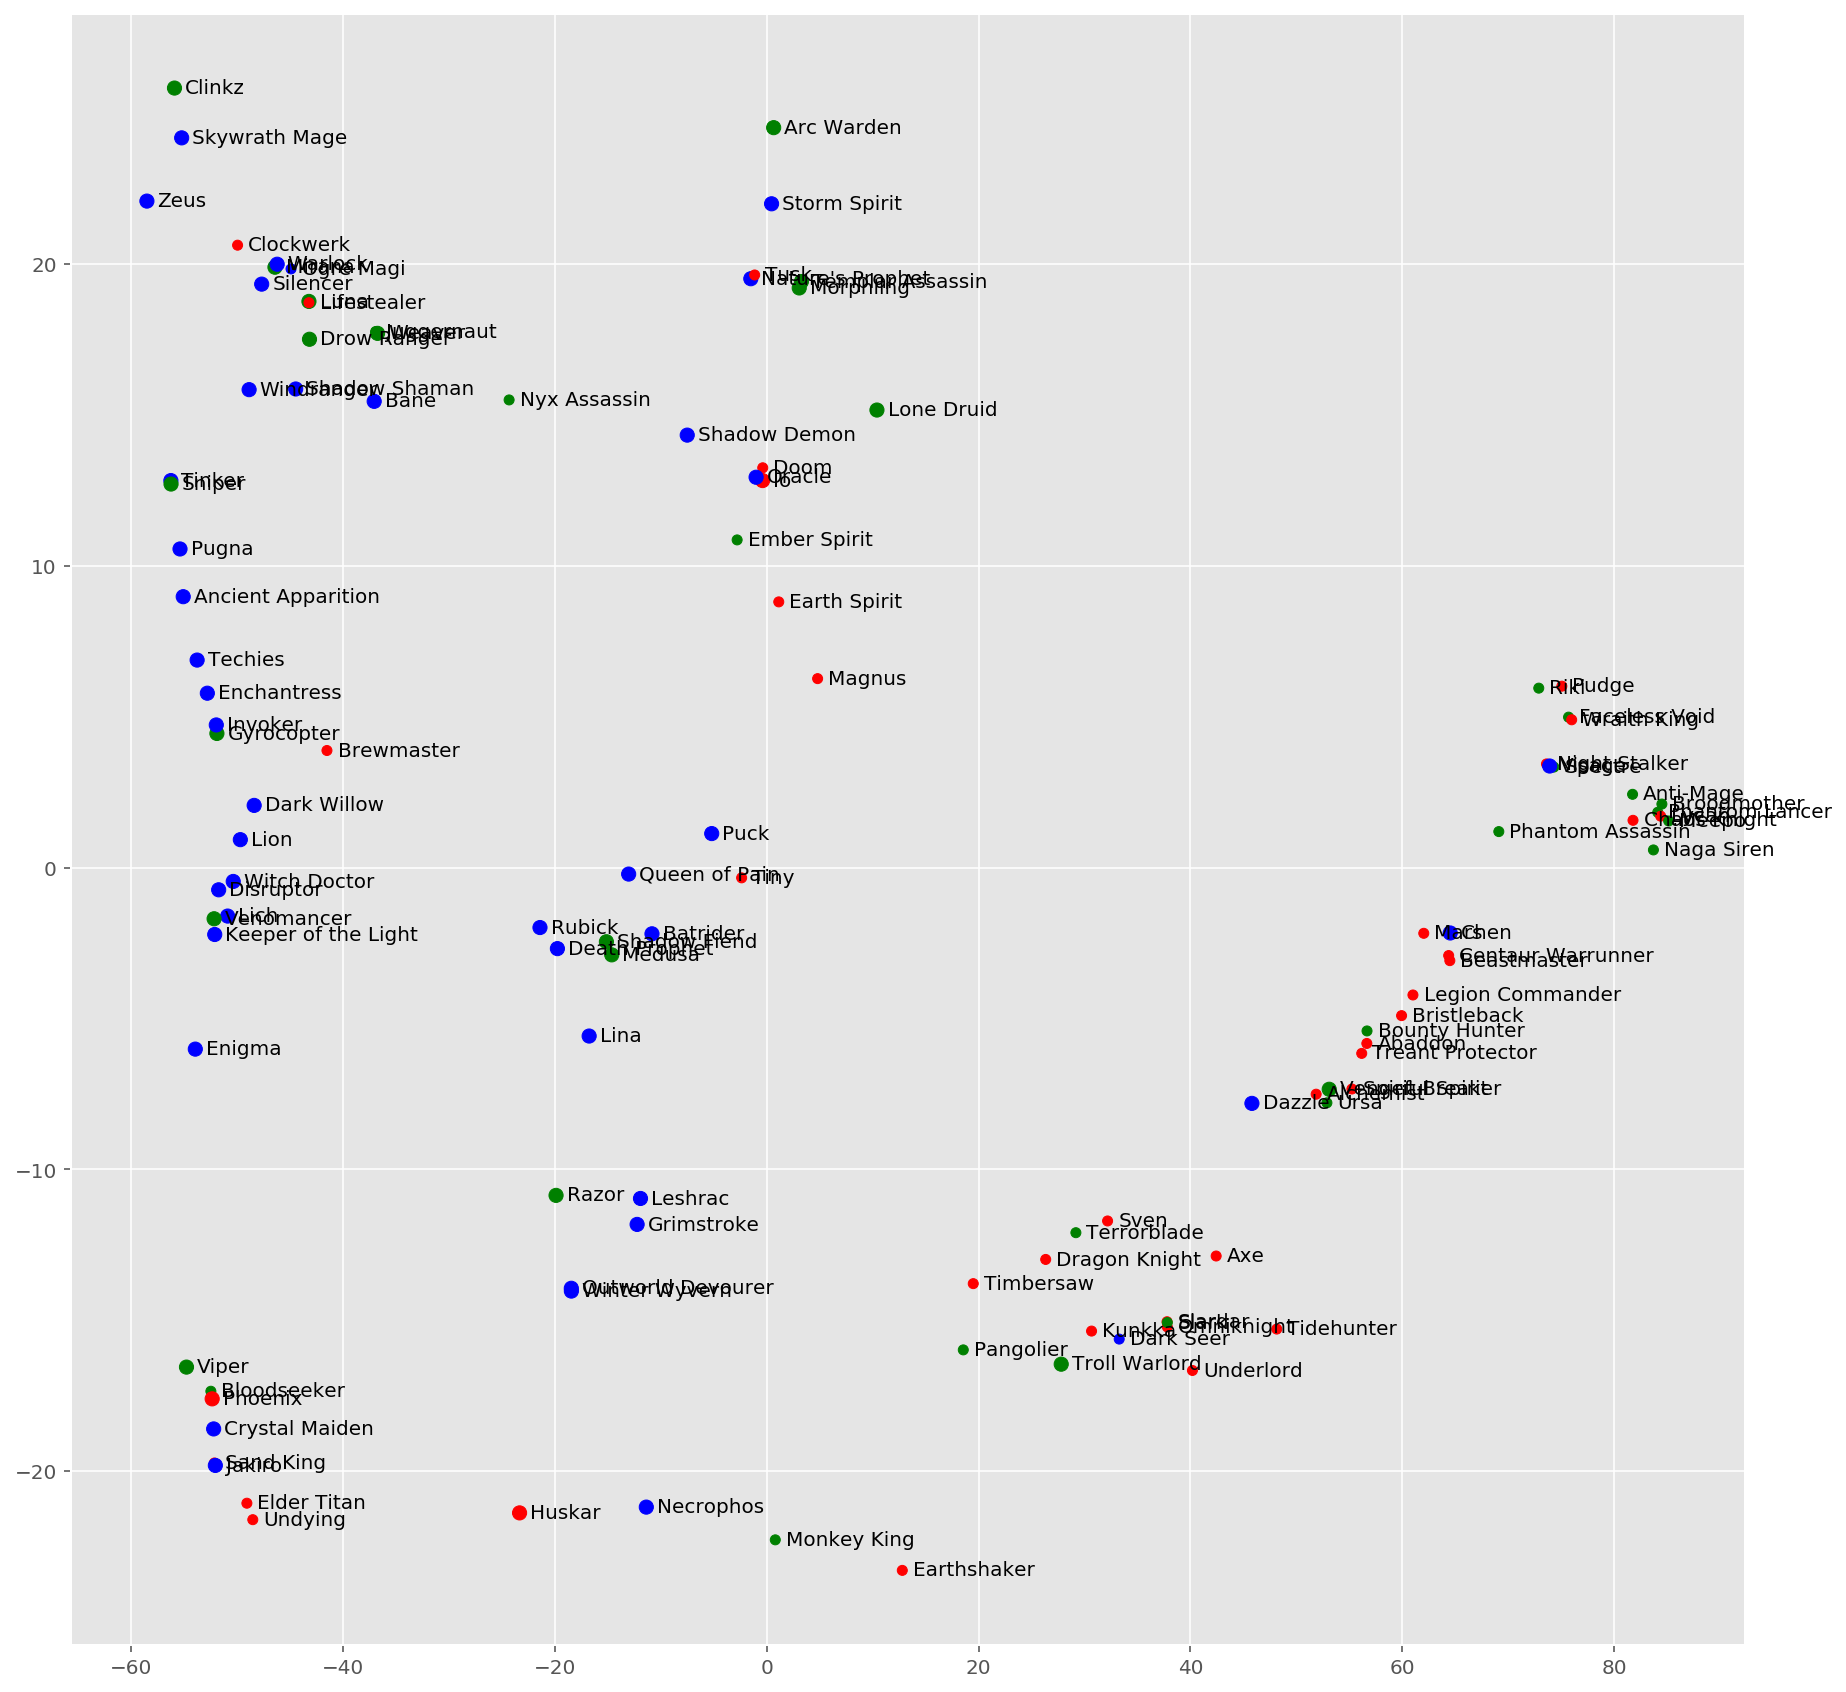

In [428]:
def col(i):
    if str(i) in heros:
        return {'agi': 'g', 'str': 'r', 'int': 'b'}[heros[str(i)]['primary_attr']]
    return 'k'

def sz(i):
    if str(i) in heros:
        return {'Melee': 25, 'Ranged': 50}[heros[str(i)]['attack_type']]
    return 1

fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(*emb_2d.T, c=[col(i) for i in range(len(emb_2d))], s=[sz(i) for i in range(len(emb_2d))])

for i, (x, y) in enumerate(emb_2d):
    if str(i) in heros:
        ax.text(x+1.0, y, heros[str(i)]['localized_name'], va='center')

# Towards Set Transformer

In [14]:
def xavier(shape, gain=1, fan=None, dtype=tf.float32):
    # receptive field * mean(in, out)
    fan = fan or (np.prod(shape[:-2]) * np.mean(shape[-2:]))
    bound = gain * np.sqrt(3 / fan)
    return tf.random.uniform(shape, -bound, bound, dtype=dtype)

def kaiming(shape, gain=1, fan=None, dtype=tf.float32):
    return xavier(shape, gain * np.sqrt(2), fan, dtype)

## 1. Dot-Attention and Multihead

In [15]:
def dot_attend(q, k, v, temperature=None, dropout=None):
    """Scaled dot-product attention as in Transformer.

    Args:
      q: BNI-tensor, the queries. (N = #queries, I = Input features)
      k: BMI-tensor, the keys. (M = #keys)
      v: BMO-tensor, the values. (O = Output features)
      temperature: scalar or None, by which to scale the logits.
        If None, defaults to sqrt(I).
      dropout: scalar or None, probability of dropout on the attention weights.

    Returns:
      Attended tensor of size BNO  (weighted values for queries.)
    """
    logits = tf.linalg.matmul(q, k, transpose_b=True)  # -> BNM
    temp = temperature or tf.sqrt(float(q.shape[-1]))
    weights = tf.nn.softmax(logits / temp)
    if dropout is not None: weights = tf.nn.dropout(weights, rate=dropout)
    return tf.linalg.matmul(weights, v)  # -> BNO


class DotAttention(tf.Module):
    """Multi-headed attention as in Transformer."""
    def __init__(self, hidden, nout=None, temperature=None, dropout=None, name=None):
        super(DotAttention, self).__init__(name=name)
        self.temperature = temperature
        self.dropout = dropout
        self.hidden = hidden
        self.nout = nout

    def _build(self, q, k, v):
        if hasattr(self, 'wq'):
            return

        nout = self.nout if self.nout is not None else q.shape[-1]
        self.wq = tf.Variable(xavier([q.shape[-1], self.hidden]), name='wq')
        self.wk = tf.Variable(xavier([k.shape[-1], self.hidden]), name='wk')
        self.wv = tf.Variable(xavier([v.shape[-1], self.hidden]), name='wv')
        self.wo = tf.Variable(kaiming([self.hidden, nout]), name='wo')

    def __call__(self, q, k, v):
        self._build(q, k, v)
        q = tf.linalg.matmul(q, self.wq)
        k = tf.linalg.matmul(k, self.wk)
        v = tf.linalg.matmul(v, self.wv)
        o = dot_attend(q, k, v, self.temperature, self.dropout)
        return tf.linalg.matmul(o, self.wo)

In [16]:
def multihead_dot_attend(q, k, v, temperature=None, dropout=None):
    """Scaled dot-product attention as in Transformer.

    Args:
      q: ...NHI-tensor, the queries. (N = #queries, H = Heads, I = Input features)
      k: ...MHI-tensor, the keys. (M = #keys)
      v: ...MHO-tensor, the values. (O = Output features)
      temperature: scalar or None, by which to scale the logits.
        If None, defaults to sqrt(I).
      dropout: scalar or None, probability of dropout on the attention weights.

    Returns:
      Attended tensor of size ...NHO  (weighted values for queries.)
    """
    # NOTE: it's been told einsum is slower than manually shaping stuff around?
    logits = tf.einsum('...nhi,...mhi->...nhm', q, k)
    temp = temperature or tf.sqrt(float(q.shape[-1]))
    weights = tf.nn.softmax(logits / temp)
    if dropout is not None: weights = tf.nn.dropout(weights, rate=dropout)
    return tf.einsum('...nhm,...mho->...nho', weights, v)


class MultiHeadDotAttention(tf.Module):
    """Multi-headed attention as in Transformer."""
    def __init__(self, nheads, nhidden, nout=None, temperature=None, dropout=None, name=None):
        super(MultiHeadDotAttention, self).__init__(name=name)
        assert nhidden % nheads == 0, '`hidden` ({}) needs to be divisible by `nheads` ({})'.format(hidden, nheads)
        self.temperature = temperature
        self.dropout = dropout
        self.nheads = nheads
        self.nhidden = nhidden
        self.nout = nout

    def _build(self, q, k, v):
        if hasattr(self, 'wq'):
            return

        nout = self.nout if self.nout is not None else q.shape[-1]
        self.wq = tf.Variable(xavier([q.shape[-1], self.nhidden]), name='wq')
        self.wk = tf.Variable(xavier([k.shape[-1], self.nhidden]), name='wk')
        self.wv = tf.Variable(xavier([v.shape[-1], self.nhidden]), name='wv')
        self.wo = tf.Variable(kaiming([self.nhidden, nout]), name='wo')

    def __call__(self, q, k, v):
        self._build(q, k, v)
        q = tf.linalg.matmul(q, self.wq)
        k = tf.linalg.matmul(k, self.wk)
        v = tf.linalg.matmul(v, self.wv)
        q = tf.reshape(q, (q.shape[0], q.shape[1], self.nheads, self.nhidden//self.nheads))
        k = tf.reshape(k, (k.shape[0], k.shape[1], self.nheads, self.nhidden//self.nheads))
        v = tf.reshape(v, (v.shape[0], v.shape[1], self.nheads, self.nhidden//self.nheads))
        o = multihead_dot_attend(q, k, v, self.temperature, self.dropout)
        o = tf.reshape(o, o.shape[:-2].as_list() + [-1])
        return tf.linalg.matmul(o, self.wo)

In [20]:
q = tf.random.normal((3, 4, 5))
k = tf.random.normal((3, 6, 5))
v = tf.random.normal((3, 6, 7))

T = 1
tf.random.set_seed(1234)
mhda = MultiHeadDotAttention(1, 72, temperature=T)
a = mhda(q, k, v)
print(a.shape)
tf.random.set_seed(1234)
da = DotAttention(72, temperature=T)
b = da(q, k, v)
print(b.shape)
np.testing.assert_allclose(a, b, atol=1e-5, rtol=1e-5)

(3, 4, 5)
(3, 4, 5)


In [21]:
q = tf.random.normal((512, 5, 128))
k = tf.random.normal((512, 5, 128))
v = tf.random.normal((512, 5, 128))

T = 1
tf.random.set_seed(1234)
mhda = MultiHeadDotAttention(1, 128, temperature=T)
a = mhda(q, k, v)
print(a.shape)
tf.random.set_seed(1234)
da = DotAttention(128, temperature=T)
b = da(q, k, v)
print(b.shape)
np.testing.assert_allclose(a, b, atol=1e-5, rtol=1e-5)

(512, 5, 128)
(512, 5, 128)


In [22]:
def into_batch(t, which):
    which = (which + t.shape.ndims) % t.shape.ndims
    shuff = list(range(t.shape.ndims))
    shuff.pop(which)
    shuff.insert(1, which)
    t = tf.transpose(t, shuff)
    return tf.reshape(t, [-1] + t.shape[2:].as_list())

def batch_into(t, which, size):
    t = tf.reshape(t, [-1, size] + t.shape[1:].as_list())
    which = (which + t.shape.ndims) % t.shape.ndims
    shuff = list(range(t.shape.ndims))
    shuff.pop(1)
    shuff.insert(which, 1)
    return tf.transpose(t, shuff)

x = tf.random.normal((3,4,5,6))
y = batch_into(into_batch(x, 2), 2, 5)
np.testing.assert_allclose(x, y)
y = batch_into(into_batch(x, -2), -2, 5)
np.testing.assert_allclose(x, y)

Timing for tiny test models:

In [727]:
%timeit mhda(q, k, v)

1.52 ms ± 69.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [728]:
%timeit da(q, k, v)

379 µs ± 170 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Timing for large models: (qkv shape: 512,5,128, 1 head)

In [718]:
%timeit mhda(q, k, v)

4.71 ms ± 94.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [667]:
%timeit da(q, k, v)

3.13 ms ± 22 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Yep, this means einsum is 1.5x to 4x slower in this case, unfortunately!

## 2. Point-wise FFNs

In [17]:
class PointFFN(tf.Module):
    """Point-wise feed-forward as in Transformer."""
    def __init__(self, nhidden, nout=None, dropout=None, name=None):
        super(PointFFN, self).__init__(name=name)
        self.nhidden = nhidden
        self.nout = nout
        self.drop = dropout

    def _build(self, x):
        if hasattr(self, 'wi'):
            return

        nout = self.nout if self.nout is not None else x.shape[-1]
        self.wi = tf.Variable(kaiming([x.shape[-1], self.nhidden]), name='wi')
        self.bi = tf.Variable(tf.zeros([self.nhidden]), name='bi')
        self.wo = tf.Variable(kaiming([self.nhidden, nout]), name='wo')
        self.bo = tf.Variable(tf.zeros([nout]), name='bo')

    def __call__(self, x):
        self._build(x)
        x = tf.linalg.matmul(x, self.wi) + self.bi
        x = tf.nn.relu(x)
        if self.drop: x = tf.nn.dropout(x, self.drop)
        x = tf.linalg.matmul(x, self.wo) + self.bo
        return x

In [24]:
PointFFN(2048)(k)

<tf.Tensor: id=739, shape=(512, 5, 128), dtype=float32, numpy=
array([[[ 0.14006695,  1.0906752 , -0.81157905, ...,  0.48258704,
          0.1198144 , -0.1804786 ],
        [-0.73054224,  0.6738945 ,  0.70346266, ..., -1.0960517 ,
          0.8141752 , -0.9119021 ],
        [-0.7846451 , -0.8211586 ,  0.6619176 , ...,  0.52131164,
         -0.1478693 ,  0.15350194],
        [ 0.17595544, -1.0231808 , -0.35552955, ...,  1.0493075 ,
         -0.20830986, -0.5422953 ],
        [ 0.622876  ,  0.28745744,  0.2795864 , ...,  0.04579978,
          0.33016896, -0.7754947 ]],

       [[ 0.33084023, -0.17475574,  0.3442597 , ...,  0.02716016,
         -0.44690612, -0.11481413],
        [ 0.46382698,  0.67835665, -0.2516097 , ...,  1.0287482 ,
         -0.4697784 , -0.756091  ],
        [-0.2895165 ,  0.26414028,  0.01523138, ...,  0.7359494 ,
          0.45674425, -0.19465405],
        [-0.31213534,  0.06487381, -0.8381369 , ...,  0.634804  ,
          0.13450697, -0.43575054],
        [ 0.12312

## 3. Multihead Attention Block (MAB and SAB)

In [18]:
def layer_normalize(x, eps=1e-5):
    m, v = tf.nn.moments(x, axes=[-1], keepdims=True)
    return (x - m) * tf.math.rsqrt(v + eps)

class LayerNorm(tf.Module):
    # It does have a learnable scale/bias, but is it necessary in transformer?
    # It seems it's always immediately followed by a new weight matrix.
    pass

In [19]:
class MultiAttBlock(tf.Module):
    """Multi-headed Attention Block as in Transformer's encoder."""
    def __init__(self, att, ffn, name=None):
        super(MultiAttBlock, self).__init__(name=name)
        self.att = att
        self.ffn = ffn

    def __call__(self, x, y):
        h = layer_normalize(x + self.att(x, y, y))
        return layer_normalize(h + self.ffn(h))

class SelfAttBlock(MultiAttBlock):
    def __call__(self, x):
        return super().__call__(x, x)

In [27]:
MultiAttBlock(MultiHeadDotAttention(8, 512), PointFFN(2048))(k, v).shape

TensorShape([512, 5, 128])

In [28]:
SelfAttBlock(MultiHeadDotAttention(8, 512), PointFFN(2048))(k).shape

TensorShape([512, 5, 128])

## 4. Pooling by Multihead Attention (PMA)

In [20]:
class PoolMultiAtt(tf.Module):
    """Pooling by multi-head attention of seeds."""
    # TODO: create the k (#out) seed vectors S, then apply MAB(S, FF(x)).
    def __init__(self, mab, nseed=1, squeeze=True, name=None):
        super(PoolMultiAtt, self).__init__(name=name)
        self.mab = mab
        self.nseed = nseed
        self.squeeze = squeeze

    def _build(self, x):
        if hasattr(self, 's'):
            return
        self.s = tf.Variable(xavier([1, self.nseed, self.mab.nhidden]), name='s')

    def __call__(self, x):
        self._build(x)
        # Unfortunately, it doesn't broadcast with the einsum used in multi-head attn.
        s_batch = tf.tile(self.s, [x.shape[0], 1, 1])
        x = self.mab(s_batch, x, x)
        if self.nseed == 1 and self.squeeze:
            x = tf.squeeze(x, axis=-2)
        return x

In [30]:
PoolMultiAtt(MultiHeadDotAttention(8, 512), squeeze=False)(k).shape

TensorShape([512, 1, 512])

## 5. SetTransformer

In [21]:
class Linear(tf.Module):
    """Point-wise feed-forward as in Transformer."""
    def __init__(self, nout, init=kaiming, name=None):
        super(Linear, self).__init__(name=name)
        self.nout = nout
        self.init = init

    def _build(self, x):
        if hasattr(self, 'w'):
            return

        self.w = tf.Variable(self.init([x.shape[-1], self.nout]), name='w')
        self.b = tf.Variable(tf.zeros([self.nout]), name='b')

    def __call__(self, x):
        self._build(x)
        return tf.linalg.matmul(x, self.w) + self.b

In [22]:
class SetTransformer1(tf.Module):
    def __init__(self, dhidden=128, nheads=4, dropout=None, name=None):
        super(SetTransformer1, self).__init__(name=name)
        self.emb = Embedding(dhidden)
        # Encoder
        self.sab1 = SelfAttBlock(
            MultiHeadDotAttention(nheads, dhidden, dropout=dropout),
            PointFFN(dhidden, dropout=dropout))
        self.sab2 = SelfAttBlock(
            MultiHeadDotAttention(nheads, dhidden, dropout=dropout),
            PointFFN(dhidden, dropout=dropout))
        # Decoder
        self.pma = PoolMultiAtt(MultiHeadDotAttention(nheads, dhidden, dropout=dropout))
        self.lin = Linear(1, init=tf.zeros)

    def __call__(self, x):
        x = self.emb(x)
        x = self.sab1(x)
        x = self.sab2(x)
        x = self.pma(x)
        x = self.lin(x)
        return x

In [832]:
model_c = SetTransformer1()
emb_c_orig = np.array(model_c.emb.w.numpy())

opt_c = tf.optimizers.Adam()
losses_c = []

In [833]:
model, opt, losses = model_c, opt_c, losses_c

for i in range(300*1000):
    if i % 100 == 0:
        print('\r{}'.format(i), end='', flush=True)
    Xb, yb = get_batch()  # B25, B
    with tf.GradientTape() as tape:
        Xb = tf.cast(tf.reshape(Xb, [-1, 10]), tf.int32)  # B(10)
        logits = model(Xb)
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=logits, labels=tf.cast(yb[:,None], tf.float32)))

    losses.append(loss.numpy())
    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))

299900

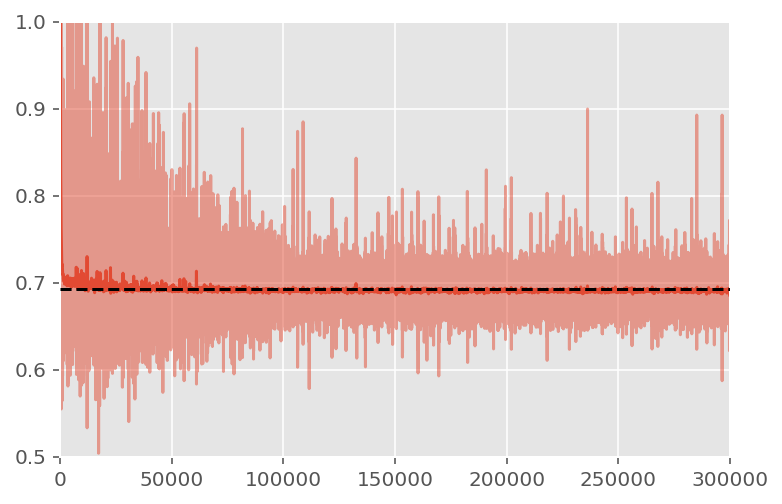

In [840]:
l, = plt.plot(np.arange(0, len(losses), 100), np.reshape(losses, (-1, 100)).mean(axis=-1))
plt.plot(losses, c=l.get_color(), alpha=0.5)
plt.xlim(0, len(losses))
plt.ylim(0.5, 1)
plt.hlines(-np.log(0.5), *plt.xlim(), ls='--', zorder=5);

In [835]:
accs = []
for Xb, yb in iter_test(bs=1024):
    Xb = tf.cast(tf.reshape(Xb, [-1, 10]), tf.int32)  # B(10)
    logits = model(Xb)
    acc = tf.reduce_mean(tf.cast(tf.cast(logits > 0, tf.uint8) == yb, tf.float32))
    accs.append(acc)
np.mean(accs)

0.53528935

# TeamTransformer?!

## Independent Teams

In [23]:
class TeamTransformer1(tf.Module):
    def __init__(self, dhidden=128, nheads=4, dropout=None, name=None):
        super(TeamTransformer1, self).__init__(name=name)
        self.emb = Embedding(dhidden)
        # Encoder
        self.sab1 = SelfAttBlock(
            MultiHeadDotAttention(nheads, dhidden, dropout=dropout),
            PointFFN(dhidden, dropout=dropout))
        self.sab2 = SelfAttBlock(
            MultiHeadDotAttention(nheads, dhidden, dropout=dropout),
            PointFFN(dhidden, dropout=dropout))
        # Decoder
        self.pma = PoolMultiAtt(MultiHeadDotAttention(nheads, dhidden, dropout=dropout))
        self.lin = Linear(1, init=tf.zeros)

    def __call__(self, radiant, dire):
        x_r = self.emb(radiant)
        x_d = self.emb(dire)
        x_r = self.sab2(self.sab1(x_r))
        x_d = self.sab2(self.sab1(x_d))
        x_r = self.pma(x_r)
        x_d = self.pma(x_d)
        elo_r = self.lin(x_r)
        elo_d = self.lin(x_d)
        return elo_d - elo_r  # Checked order (label 0 == radiant win)
        #return self.lin(tf.concat([x_r, x_d], axis=-1))

In [42]:
TeamTransformer1()(Xb[:,0,:], Xb[:,1,:]).shape

TensorShape([32, 1])

In [43]:
model_d = TeamTransformer1()
emb_d_orig = np.array(model_d.emb.w.numpy())

opt_d = tf.optimizers.Adam()
losses_d = []

In [44]:
model, opt, losses = model_d, opt_d, losses_d

for i in range(350*1000):
    if i % 100 == 0:
        print('\r{}'.format(i), end='', flush=True)
    Xb, yb = get_batch()  # B25, B
    with tf.GradientTape() as tape:
        Xb = tf.cast(Xb, tf.int32)
        logits = model(Xb[:,0,:], Xb[:,1,:])
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=logits, labels=tf.cast(yb[:,None], tf.float32)))

    losses.append(loss.numpy())
    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))

349900

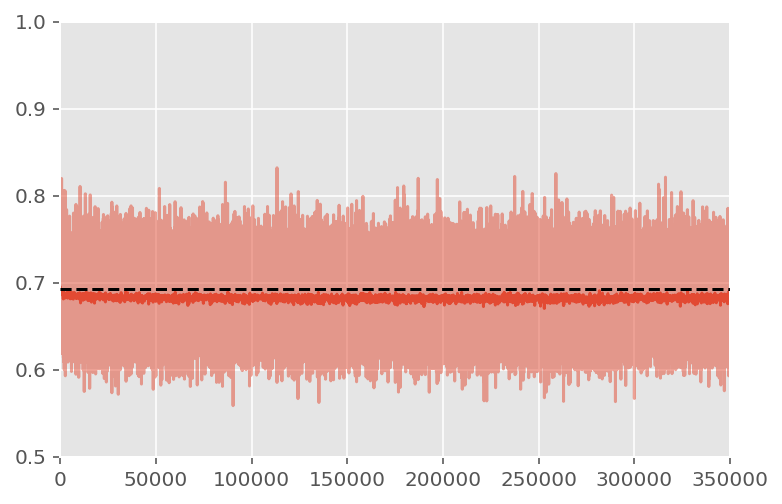

In [45]:
l, = plt.plot(np.arange(0, len(losses), 100), np.reshape(losses, (-1, 100)).mean(axis=-1))
plt.plot(losses, c=l.get_color(), alpha=0.5)
plt.xlim(0, len(losses))
plt.ylim(0.5, 1)
plt.hlines(-np.log(0.5), *plt.xlim(), ls='--', zorder=5);

In [46]:
accs = []
for Xb, yb in iter_test(bs=1024):
    print('\r{}'.format(len(accs)), end='', flush=True)
    Xb = tf.cast(Xb, tf.int32)
    logits = model(Xb[:,0,:], Xb[:,1,:])
    acc = tf.reduce_mean(tf.cast(tf.cast(logits > 0, tf.uint8) == yb, tf.float32))
    accs.append(acc)
print()
np.mean(accs)

2954


0.5000287

## 1b

In [33]:
class TeamTransformer1b(tf.Module):
    def __init__(self, dhidden=128, nheads=4, dropout=None, name=None):
        super(TeamTransformer1b, self).__init__(name=name)
        self.emb = Embedding(dhidden)
        # Encoder
        self.sab1 = SelfAttBlock(
            MultiHeadDotAttention(nheads, dhidden, dropout=dropout),
            PointFFN(dhidden, dropout=dropout))
        self.sab2 = SelfAttBlock(
            MultiHeadDotAttention(nheads, dhidden, dropout=dropout),
            PointFFN(dhidden, dropout=dropout))
        # Decoder
        self.pma = PoolMultiAtt(MultiHeadDotAttention(nheads, dhidden, dropout=dropout))
        self.lin1 = Linear(dhidden)
        self.lin2 = Linear(1, init=tf.zeros)

    def __call__(self, radiant, dire):
        x_r = self.emb(radiant)
        x_d = self.emb(dire)
        x_r = self.sab2(self.sab1(x_r))
        x_d = self.sab2(self.sab1(x_d))
        x_r = self.pma(x_r)
        x_d = self.pma(x_d)
        return self.lin2(tf.nn.relu(self.lin1(tf.concat([x_r, x_d], axis=-1))))

In [34]:
TeamTransformer1b()(Xb[:,0,:], Xb[:,1,:]).shape

TensorShape([108, 1])

In [36]:
model_d1b = TeamTransformer1b()
emb_d1b_orig = np.array(model_d1b.emb.w.numpy())

opt_d1b = tf.optimizers.Adam()
losses_d1b = []

In [37]:
model, opt, losses = model_d1b, opt_d1b, losses_d1b

for i in range(250*1000):
    if i % 100 == 0:
        print('\r{}'.format(i), end='', flush=True)
    Xb, yb = get_batch()  # B25, B
    with tf.GradientTape() as tape:
        Xb = tf.cast(Xb, tf.int32)
        logits = model(Xb[:,0,:], Xb[:,1,:])
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=logits, labels=tf.cast(yb[:,None], tf.float32)))

    losses.append(loss.numpy())
    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))

249900

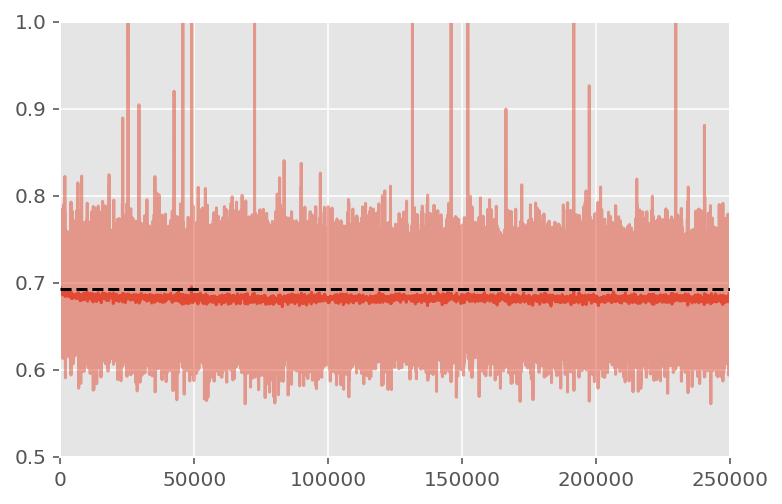

In [38]:
l, = plt.plot(np.arange(0, len(losses), 100), np.reshape(losses, (-1, 100)).mean(axis=-1))
plt.plot(losses, c=l.get_color(), alpha=0.5)
plt.xlim(0, len(losses))
plt.ylim(0.5, 1)
plt.hlines(-np.log(0.5), *plt.xlim(), ls='--', zorder=5);

In [39]:
accs = []
for Xb, yb in iter_test(bs=1024):
    print('\r{}'.format(len(accs)), end='', flush=True)
    Xb = tf.cast(Xb, tf.int32)
    logits = model(Xb[:,0,:], Xb[:,1,:])
    acc = tf.reduce_mean(tf.cast(tf.cast(logits > 0, tf.uint8) == yb, tf.float32))
    accs.append(acc)
print()
np.mean(accs)

2954


0.5092116

## 2

In [24]:
class TeamTransformer2(tf.Module):
    def __init__(self, dhidden=128, nheads=4, dropout=None, name=None):
        super(TeamTransformer2, self).__init__(name=name)
        self.emb = Embedding(dhidden)
        # Encoder
        self.sab1 = SelfAttBlock(
            MultiHeadDotAttention(nheads, dhidden, dropout=dropout),
            PointFFN(dhidden, dropout=dropout))
        self.sab2 = SelfAttBlock(
            MultiHeadDotAttention(nheads, dhidden, dropout=dropout),
            PointFFN(dhidden, dropout=dropout))
        # Decoder
        self.pma = PoolMultiAtt(MultiHeadDotAttention(nheads, dhidden, dropout=dropout),
                                squeeze=False)
        self.sab3 = SelfAttBlock(
            MultiHeadDotAttention(nheads, dhidden, dropout=dropout),
            PointFFN(dhidden, dropout=dropout))
        self.sab4 = SelfAttBlock(
            MultiHeadDotAttention(nheads, dhidden, dropout=dropout),
            PointFFN(dhidden, dropout=dropout))
        self.lin = Linear(1, init=tf.zeros)

    def __call__(self, radiant, dire):
        x_r = self.emb(radiant)
        x_d = self.emb(dire)
        x_r = self.sab2(self.sab1(x_r))
        x_d = self.sab2(self.sab1(x_d))
        x_r = self.pma(x_r)
        x_d = self.pma(x_d)
        x_r = self.sab4(self.sab3(x_r))
        x_d = self.sab4(self.sab3(x_d))
        elo_r = self.lin(x_r[:,0,:])
        elo_d = self.lin(x_d[:,0,:])
        return elo_d - elo_r  # Checked order (label 0 == radiant win)
        #return self.lin(tf.concat([x_r, x_d], axis=-1))

In [25]:
TeamTransformer2()(Xb[:,0,:], Xb[:,1,:]).shape

NameError: name 'Xb' is not defined

In [26]:
model_d2 = TeamTransformer2()
emb_d2_orig = np.array(model_d2.emb.w.numpy())

opt_d2 = tf.optimizers.Adam()
losses_d2 = []

In [27]:
model, opt, losses = model_d2, opt_d2, losses_d2

for i in range(200*1000):
    if i % 100 == 0:
        print('\r{}'.format(i), end='', flush=True)
    Xb, yb = get_batch()  # B25, B
    with tf.GradientTape() as tape:
        Xb = tf.cast(Xb, tf.int32)
        logits = model(Xb[:,0,:], Xb[:,1,:])
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=logits, labels=tf.cast(yb[:,None], tf.float32)))

    losses.append(loss.numpy())
    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))

199900

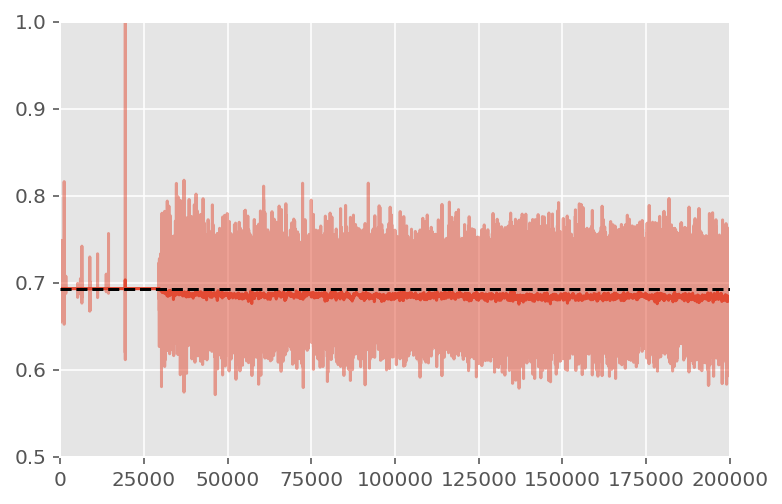

In [28]:
l, = plt.plot(np.arange(0, len(losses), 100), np.reshape(losses, (-1, 100)).mean(axis=-1))
plt.plot(losses, c=l.get_color(), alpha=0.5)
plt.xlim(0, len(losses))
plt.ylim(0.5, 1)
plt.hlines(-np.log(0.5), *plt.xlim(), ls='--', zorder=5);

In [30]:
accs = []
for Xb, yb in iter_test(bs=1024):
    print('\r{}'.format(len(accs)), end='', flush=True)
    Xb = tf.cast(Xb, tf.int32)
    logits = model(Xb[:,0,:], Xb[:,1,:])
    acc = tf.reduce_mean(tf.cast(tf.cast(logits > 0, tf.uint8) == yb, tf.float32))
    accs.append(acc)
print()
np.mean(accs)

2954


0.5000257

## Cross-team peeking